# 🧠 CNN vs MLP on CIFAR10

This notebook compares Convolutional Neural Networks (CNNs) and Multilayer Perceptrons (MLPs) on the CIFAR10 image classification task.  
We'll explore differences in training performance, number of parameters, robustness to translations, and visualize feature maps.

---

## ⚙️ Setup

In [1]:
from typing import Callable

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer

from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

from tqdm.notebook import trange

# Exercise 8 - Convolutional Neural Networks

In this exercise we will create and train convolutional neural networks on the PyTorch dataset.

We will first write functions for both creation of MLPs (already implemented) and CNNs. Then we will train multiple MLPs and CNNs on the CIFAR10 dataset and compare their performance and number of parameters, as well as visualize the feature maps of the CNN. Finally we will investigate the robustness of CNNs against small translations of images.

# Hyperparameters

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

TRAIN_SPLIT = 0.5
VAL_SPLIT = 0.05

BATCH_SIZE = 128
EPOCHS = 5
LEARNING_RATE = 0.001

Using device: cpu


# Datasets

### Task 1 (10 P)
Use the `torch.utils.data.random_split()` function to further split the training set into train and validation set. Use the constants `TRAIN_SPLIT` and `VAL_SPLIT` as the percentages to take from the original training set.

In [3]:
dataset = CIFAR10("sample_data", train=True, transform=ToTensor(), download=True)

# Calculate the lengths for each split
train_len = int(len(dataset) * TRAIN_SPLIT)
val_len = int(len(dataset) * VAL_SPLIT)
discard_len = len(dataset) - train_len - val_len

# Split the dataset
train_set, val_set, _ = torch.utils.data.random_split(dataset, [train_len, val_len, discard_len])

test_set = CIFAR10("sample_data", train=False, transform=ToTensor(), download=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


# MLP

Implementation of MLP is given.

In [4]:
def create_mlp(input_shape: tuple[int, int, int], hidden_dims: list[int], n_classes: int):
    dims = [np.prod(input_shape), *hidden_dims, n_classes]

    layers = []
    for i in range(len(dims) - 1):
        if i < len(dims) - 2:
            layers.extend([nn.Linear(dims[i], dims[i+1]), nn.ReLU()])
        else:
            layers.extend([nn.Linear(dims[i], dims[i+1])])

    model = nn.Sequential(
        nn.Flatten(),
        *layers,
    )

    return model.to(DEVICE)

## 🧱 CNN Architecture

### Task 2 (20P)

We implement a convolutional neural network with a flexible number of layers and channels, followed by a projection head. The CNN automatically adapts to the input image size by using a dummy forward pass to determine the flattened dimension.


In [5]:
def create_cnn(input_shape: tuple[int, int, int], channels: list[int], n_classes: int):
    # input_shape: (C, H, W)
    C, H, W = input_shape

    layers = []
    in_channels = C

    # Build convolutional blocks
    for out_channels in channels:
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2))
        layers.append(nn.MaxPool2d(kernel_size=4, stride=2, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels

    conv_part = nn.Sequential(*layers)

    # Determine the number of features after the conv part:
    # Run a single dummy input through the conv_part to see what the flattened size is.
    dummy_input = torch.zeros((1, C, H, W))  # batch size = 1
    with torch.no_grad():
        conv_output = conv_part(dummy_input)
    # conv_output shape is [1, channels[-1], H_out, W_out]

    # Flatten everything except batch dimension
    conv_output_shape = conv_output.shape
    flattened_dim = conv_output_shape[1] * conv_output_shape[2] * conv_output_shape[3]

    # Projection head
    # Maps the flattened conv features to n_classes
    head = nn.Linear(flattened_dim, n_classes)

    model = nn.Sequential(
        conv_part,
        nn.Flatten(),
        head
    )

    return model.to(DEVICE)

# Train and validation functions

The functions for training and evaluating the models are given.

In [6]:
def train_one_epoch(model: nn.Module, train_loader: DataLoader,
                    optimizer: Optimizer, loss_fn: Callable):
    losses = []

    for batch, labels in train_loader:
        batch, labels = batch.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        preds = model(batch)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return np.mean(losses)


def validate(model: nn.Module, val_loader: DataLoader, loss_fn: Callable):
    losses = []

    model.eval()

    with torch.no_grad():
        for batch, labels in val_loader:
            batch, labels = batch.to(DEVICE), labels.to(DEVICE)
            preds = model(batch)
            loss = loss_fn(preds, labels)

            losses.append(loss.item())

    model.train()

    return np.mean(losses)


def train_model(model: nn.Module, train_loader, val_loader,
                optimizer: Optimizer, loss_fn: Callable, n_epochs: int,
                validate_every: int = 1):
    train_losses = []
    val_losses = []

    # stores the iterations in which we validated our model for plotting
    val_epochs = []

    progress_bar = trange(n_epochs)
    for epoch in progress_bar:
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
        train_losses.append(train_loss)

        if epoch % validate_every == 0 or epoch in [1, n_epochs - 1]:
            val_loss = validate(model, val_loader, loss_fn)
            val_losses.append(val_loss)
            val_epochs.append(epoch)

        progress_bar.set_description(f"Train loss: {train_loss:.4f}\t Val loss: {val_loss:.4f}")

    # The first epoch often results in very high losses due to random guesses at
    # the beginning of training. To avoid the effect on the plot you may
    # uncomment the following line.

    # return train_losses[1:], val_losses[1:], [e-1 for e in val_epochs][1:]

    return train_losses, val_losses, val_epochs

## 🔁 Training: CNN vs MLP

### Task 3 (10P)

We now train three CNNs and three MLPs on the CIFAR10 dataset using the Adam optimizer and compare their training/validation losses.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

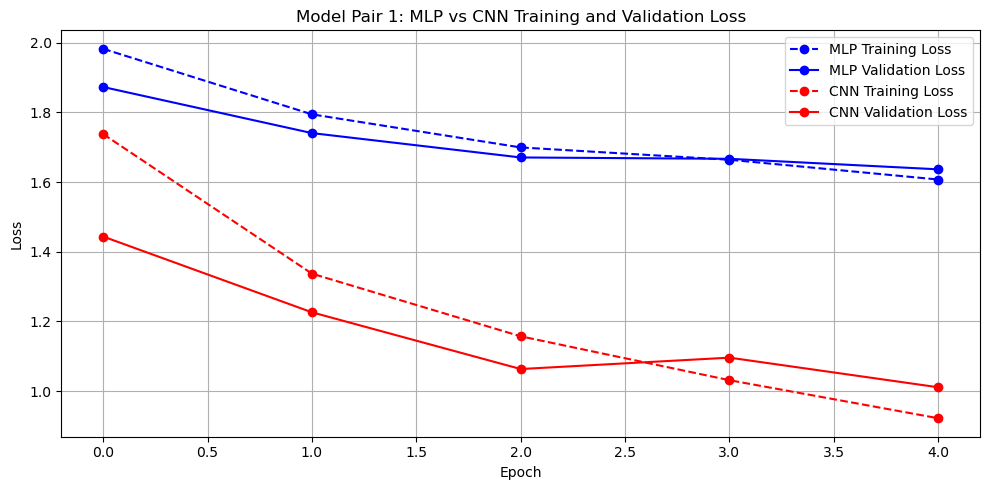

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

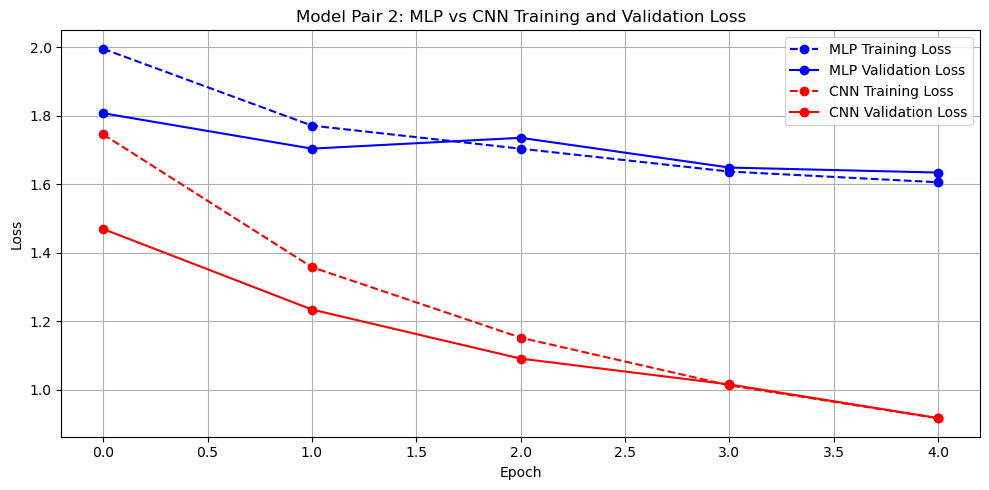

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

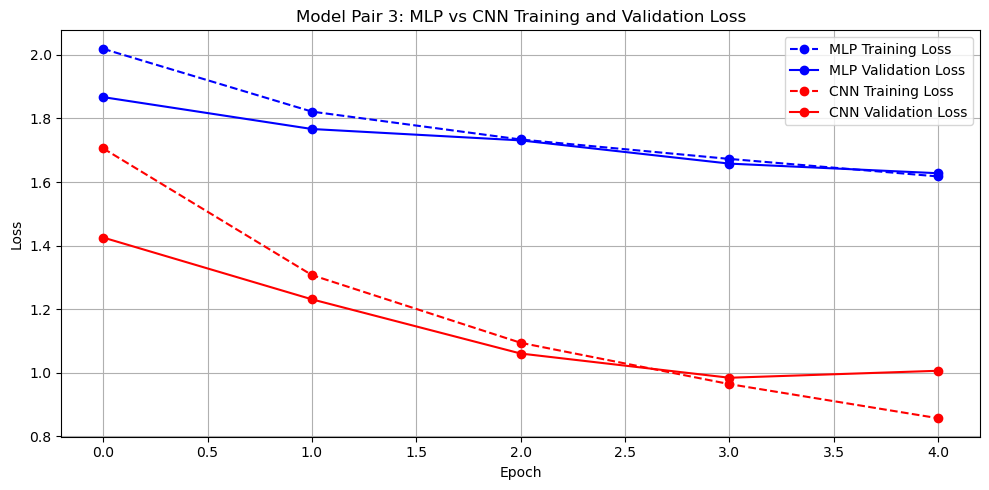

✅ Trained 3 MLPs and 3 CNNs.


In [7]:
mlps: list[nn.Module] = []
cnns: list[nn.Module] = []

input_shape = (3, 32, 32)
cnn_channels = [64, 96, 128]
mlp_dims = [1024, 512, 64]
n_classes = 10

mlp_train_losses_all = []
mlp_val_losses_all = []
mlp_val_epochs_all = []

cnn_train_losses_all = []
cnn_val_losses_all = []
cnn_val_epochs_all = []

# Single loop that trains one MLP and one CNN in each iteration
for i in range(3):
    # Train MLP
    mlp = create_mlp(input_shape, mlp_dims, n_classes)
    optimizer = optim.Adam(mlp.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()

    mlp_train_losses, mlp_val_losses, mlp_val_epochs = train_model(
        mlp,
        train_loader,
        val_loader,
        optimizer,
        loss_fn,
        n_epochs=EPOCHS,
        validate_every=1
    )
    
    mlps.append(mlp)
    mlp_train_losses_all.append(mlp_train_losses)
    mlp_val_losses_all.append(mlp_val_losses)
    mlp_val_epochs_all.append(mlp_val_epochs)

    # Train CNN
    cnn = create_cnn(input_shape, cnn_channels, n_classes)
    optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()

    cnn_train_losses, cnn_val_losses, cnn_val_epochs = train_model(
        cnn,
        train_loader,
        val_loader,
        optimizer,
        loss_fn,
        n_epochs=EPOCHS,
        validate_every=1
    )
    
    cnns.append(cnn)
    cnn_train_losses_all.append(cnn_train_losses)
    cnn_val_losses_all.append(cnn_val_losses)
    cnn_val_epochs_all.append(cnn_val_epochs)

    # --- Plot losses for this MLP/CNN pair ---
    plt.figure(figsize=(10, 5))
    
    plt.plot(range(EPOCHS), mlp_train_losses, color='blue', marker='o', linestyle='--', label='MLP Training Loss')
    plt.plot(mlp_val_epochs, mlp_val_losses, color='blue', marker='o', label='MLP Validation Loss')
    
    plt.plot(range(EPOCHS), cnn_train_losses, color='red', marker='o', linestyle='--', label='CNN Training Loss')
    plt.plot(cnn_val_epochs, cnn_val_losses, color='red', marker='o', label='CNN Validation Loss')

    plt.title(f"Model Pair {i+1}: MLP vs CNN Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f"plots/mlp_cnn_loss_pair{i+1}.png")
    plt.show()

print(f"✅ Trained {len(mlps)} MLPs and {len(cnns)} CNNs.")

# 📈 Evaluation and Visualization

### ✅ Task 4a (20P) — Accuracy Comparison

We compute the test accuracy of all trained MLPs and CNNs and compare them via a boxplot.


/var/folders/kb/nvs3vt_s7_1fbjz8lm6rnn5w0000gn/T/ipykernel_69496/2560985708.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mlp_accuracies, cnn_accuracies], labels=["MLPs", "CNNs"])


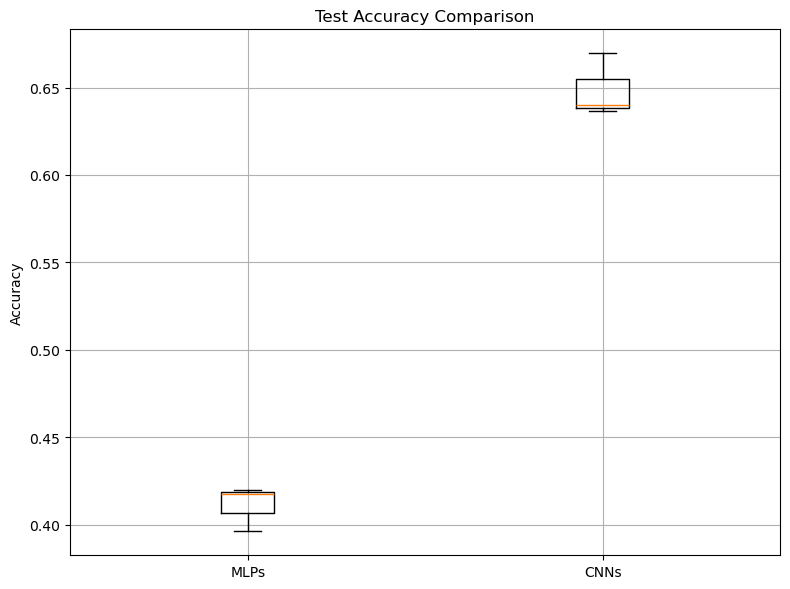

Average MLP accuracy on images: 0.4112
Average CNN accuracy on images: 0.6488


In [ ]:
def get_accuracy(model: nn.Module, dataloader: DataLoader):
    """Compute accuracy of model on the given dataloader."""
    accuracies = []

    model.eval()
    with torch.no_grad():
        for batch, labels in dataloader:
            batch, labels = batch.to(DEVICE), labels.to(DEVICE)
            preds = model(batch)
            acc = torch.mean((torch.argmax(preds, dim=-1) == labels).float())
            accuracies.append(acc)

    model.train()
    return np.mean(accuracies)

# Compute accuracies
mlp_accuracies = [get_accuracy(m, test_loader) for m in mlps]
cnn_accuracies = [get_accuracy(c, test_loader) for c in cnns]

# Plot
plt.figure(figsize=(8,6))
plt.boxplot([mlp_accuracies, cnn_accuracies], labels=["MLPs", "CNNs"])
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/accuracy_boxplot.png")
plt.show()

# Print average values
avg_mlp_acc = np.average(mlp_accuracies)
avg_cnn_acc = np.average(cnn_accuracies)

print(f"Average MLP accuracy on images: {avg_mlp_acc:.4f}")
print(f"Average CNN accuracy on images: {avg_cnn_acc:.4f}")

### 📦 Task 4b (10P) — Model Size
We compute the number of trainable parameters in both architectures.

In [9]:
def count_params(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

mlp_params = count_params(mlps[0])
cnn_params = count_params(cnns[0])

print(f"MLP:\t{mlp_params:,} trainable parameters")
print(f"CNN:\t{cnn_params:,} trainable parameters")
print(f"CNN is ~{(mlp_params / cnn_params):.2f}x smaller than the MLP.")


MLP:	3,705,034 trainable parameters
CNN:	486,378 trainable parameters
CNN is ~7.62x smaller than the MLP.


### 🧠 Task 4c (20P) — Visualizing CNN Feature Maps
We visualize intermediate feature maps of the first CNN after each convolutional block.

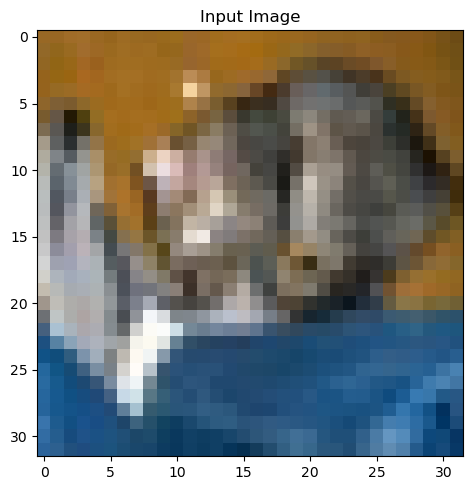

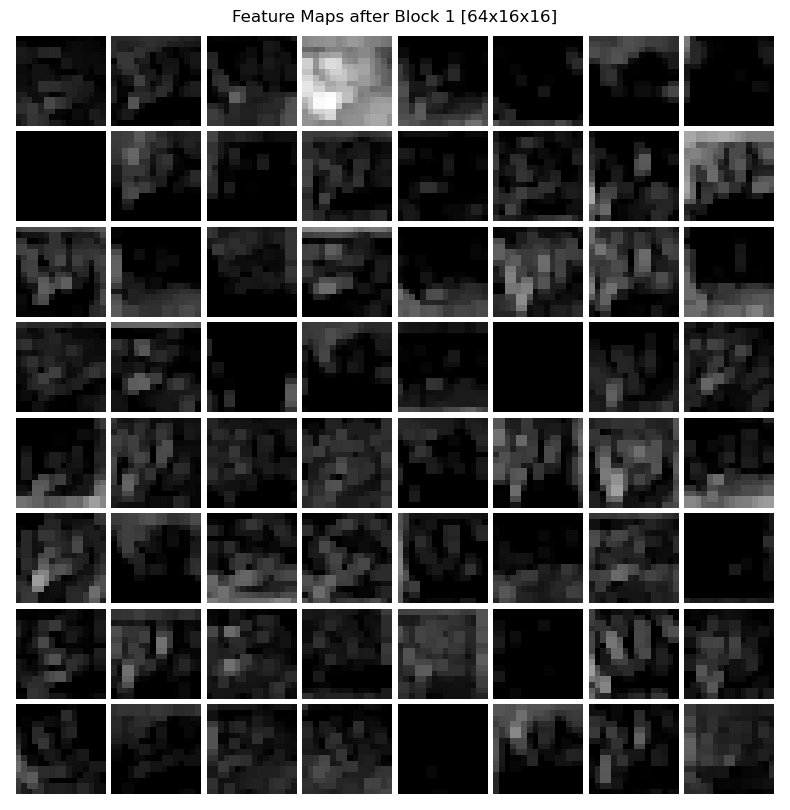

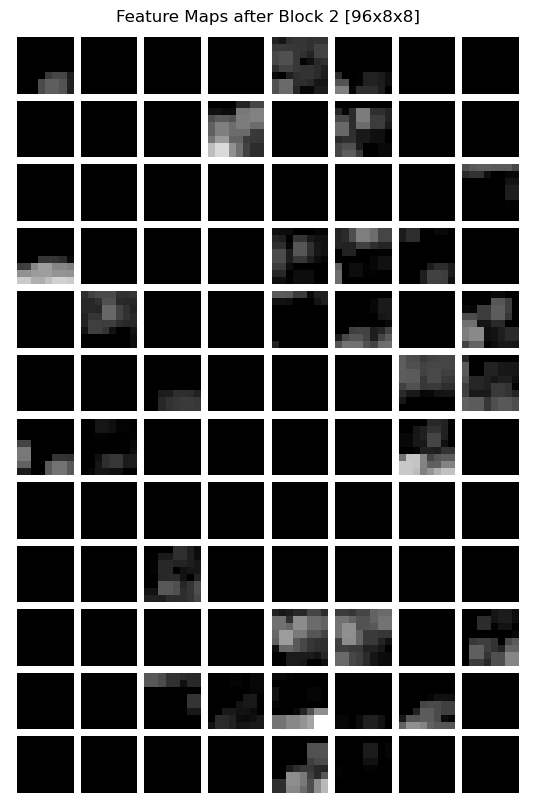

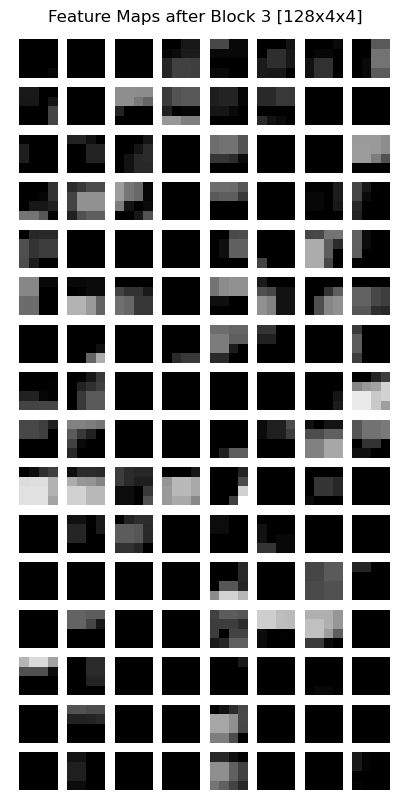

In [10]:
first_cifar_test_image = next(iter(test_loader))[0][0][None, :]
model = cnns[0]

model.eval()
with torch.no_grad():
    x = first_cifar_test_image.to(DEVICE)

    # After first block (conv, pool, relu)
    out_layer2 = model[0][:3](x)
    # After second block (conv, pool, relu)
    out_layer5 = model[0][:6](x)
    # After third block (conv, pool, relu)
    out_layer8 = model[0][:9](x)

def normalize_feature_maps(fm):
    fm_min, fm_max = fm.min(), fm.max()
    return (fm - fm_min) / (fm_max - fm_min + 1e-8)

def plot_feature_maps(fmaps, title, nrow=8, filename=None):
    fmaps = fmaps.cpu().squeeze(0).unsqueeze(1)  # [1, C, H, W] → [C, 1, H, W]
    fmaps_norm = normalize_feature_maps(fmaps)

    grid = make_grid(fmaps_norm, nrow=nrow, normalize=False, padding=1, pad_value=1.0)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    if filename:
        plt.savefig(f"plots/{filename}")
    plt.show()

# Input image
input_img = first_cifar_test_image[0].permute(1,2,0).cpu().numpy()
input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min() + 1e-8)

plt.figure(figsize=(5,5))
plt.imshow(input_img)
plt.title("Input Image")
plt.axis('on')
plt.tight_layout()
plt.savefig("plots/cnn_input_image.png")
plt.show()


# Plot the feature maps
plot_feature_maps(out_layer2, "Feature Maps after Block 1 [64x16x16]", filename="cnn_layer1_maps.png")
plot_feature_maps(out_layer5, "Feature Maps after Block 2 [96x8x8]", filename="cnn_layer2_maps.png")
plot_feature_maps(out_layer8, "Feature Maps after Block 3 [128x4x4]", filename="cnn_layer3_maps.png")


### 🌀 Task 5 (10P) — Robustness to Image Translations

To evaluate model robustness, we test all models on a translated version of the CIFAR10 dataset.  
We apply small random spatial translations of up to 3 pixels in each direction.


Files already downloaded and verified


/var/folders/kb/nvs3vt_s7_1fbjz8lm6rnn5w0000gn/T/ipykernel_69496/4260835742.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mlp_accuracies_translated, cnn_accuracies_translated], labels=["MLPs", "CNNs"])


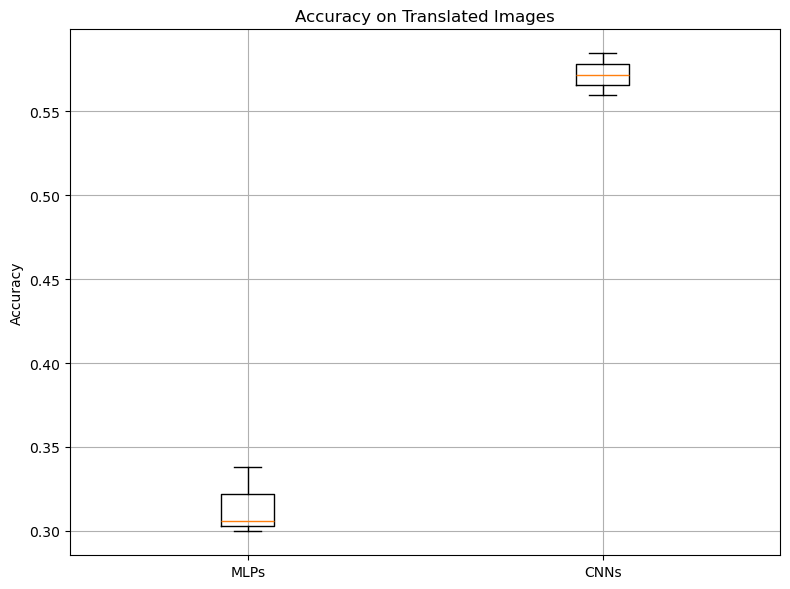

Max MLP accuracy on translated images: 0.3147
Max CNN accuracy on translated images: 0.5718


In [ ]:
translate = (3/32, 3/32)  # max ~3px shift

test_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=translate),
    transforms.ToTensor()
])

test_set_translated = CIFAR10(
    root='sample_data',
    train=False,
    download=True,
    transform=test_transform
)
test_loader_translated = DataLoader(test_set_translated, batch_size=BATCH_SIZE, shuffle=False)

# Compute accuracies for all MLPs on the translated test set
mlp_accuracies_translated = [get_accuracy(m, test_loader_translated) for m in mlps]
# Compute accuracies for all CNNs on the translated test set
cnn_accuracies_translated = [get_accuracy(c, test_loader_translated) for c in cnns]

plt.figure(figsize=(8, 6))
plt.boxplot([mlp_accuracies_translated, cnn_accuracies_translated], labels=["MLPs", "CNNs"])
plt.title("Accuracy on Translated Images")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/translated_accuracy_boxplot.png")
plt.show()

# Print average values
avg_mlp_acc = np.average(mlp_accuracies_translated)
avg_cnn_acc = np.average(cnn_accuracies_translated)

print(f"Average MLP accuracy on images: {avg_mlp_acc:.4f}")
print(f"Average CNN accuracy on images: {avg_cnn_acc:.4f}")


## 🧠 Summary
CNNs showed significantly better robustness to spatial translations than MLPs.
This result is expected, as CNNs are translation-equivariant by design due to the nature of convolutional layers and local receptive fields.